In [1]:
'''
Build simple text classification model using a logistic classifier to determine sentiment of 
reviews on baby products and to help identify positive and negative review similarities, and
probability of positive given the review text
'''

#TODO:  Research ROC curve more; research sklearn's Feature Extraction tools


%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from collections import Counter

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer

# Grab data and and preview
products = pd.read_csv(r'../data/amazon_baby.csv')[:30000]

products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [2]:
print('Total number of reviews:', len(products))

Total number of reviews: 30000


In [3]:
# Find average rating of top 10 most reviewd products
cols = ['name', 'rating']

avg_review = products[cols].groupby('name').agg({'rating': [np.size, np.mean]})
top_avg_review = avg_review.sort_values([('rating','size')], ascending= False)[:10]
top_avg_review

rating          
                                                     size      mean
name                                                               
Cloud b Twilight Constellation Night Light, Turtle    520  4.538462
Fisher-Price Booster Seat, Blue/Green/Gray            489  4.715746
Leachco Snoogle Total Body Pillow                     388  4.414948
Baby Trend Diaper Champ                               333  4.072072
Leachco Back \'N Belly Contoured Body Pillow, I...    283  4.360424
North States Superyard Play Yard, Grey, 6 Panel       281  4.416370
BABYBJORN Potty Chair - Red                           232  4.577586
Fisher-Price Rainforest Melodies and Lights Del...    232  4.547414
The First Year\'s Infant To Toddler Tub with Sl...    230  4.413043
Fisher-Price Infant-To-Toddler Rocker, Blue/Green     217  4.290323

In [4]:
print('Number of products:', len(avg_review))

Number of products: 2808


In [5]:
# Experiment with adding a calculated test column

products['testCol'] = products[('rating')] + 1
products.head()

,name,review,rating,testCol
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,4
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,6
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,6
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,6
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,6


In [6]:
# Remove (drop) test column

products = products.drop('testCol', axis= 1)
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [7]:
# Create function to count occurance of each word in review
def word_count(x):
    '''
    Takes input, x, converts it to a string, and returns dictionary of the count of each word.
    
    input:
    x = 'apples are apples'
    
    output:
    {'apples': 2, 'are': 1}

    '''
    word_string = str(x).split()
    word_count = dict(Counter(word_string))
    return word_count

# Create new column, apply word count function to all reviews, and place output in new column
products['word_count'] = products['review'].apply(word_count)

In [8]:
# Output sample to file
#products.head(100).to_csv(r'../data/products_word_vector.csv')

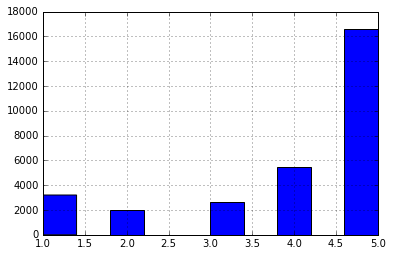

In [9]:
# Show distribution of ratings
# NOTE: Most are 5 stars to begin with
products['rating'].hist()

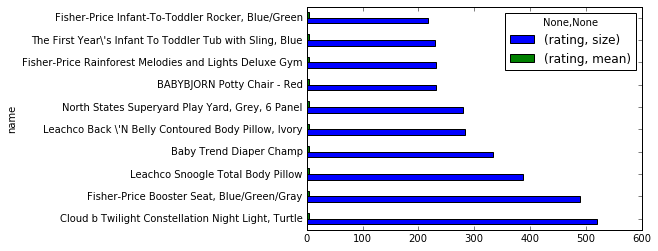

In [10]:
# Show top 10 products by number of reviews
top_avg_review.plot(kind='barh')

In [11]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 
                  'bad', 'terrible', 'awful', 'wow', 'hate']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12016eb70>]], dtype=object)

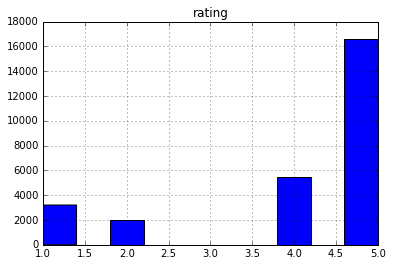

In [12]:
# Remove all 3 star reviews
products = products[products['rating'] != 3]
products.hist()

In [13]:
# New number of reviews
print('New number of reviews', len(products))

New number of reviews 27349


In [14]:
# Add column to indicate positive (desired) sentiment
products['pos_sentiment'] = products['rating'] >= 4
products.head()

,name,review,rating,word_count,pos_sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'highly': 1, 'holder.': 1, 'disappointed.': 1...",True
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'warmer': 1, 'this': 1, 'perfectly...would': ...",True
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'ingenious': 1, 'it': 1, 'well': 1, 'have': 1...",True
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'help': 1, 'To': 1, 'must': 1, 'when': 1, 'ha...",True
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'help': 2, 'highly': 1, 'cute': 1, 'any': 2, ...",True


In [15]:
v = DictVectorizer(sparse=True) #default; produces scipy.sparse matricies 

X = v.fit_transform(products['word_count'])
y = products['pos_sentiment'].values

In [16]:
X.shape

(27349, 89296)

In [17]:
y.shape

(27349,)

In [18]:
clf_model = linear_model.LogisticRegression()
clf_model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
clf_model.score(X, y)

0.99436908113642186

In [20]:
y.mean()

0.80832937218911116

In [21]:
type(y)

numpy.ndarray

In [22]:
# Divide the data into training and test sets
# Divide data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.2, 
                                                    random_state= 0)  #random_state==seed

In [26]:
X_train.shape

(21879, 89296)

In [27]:
X_test.shape

(5470, 89296)

In [30]:
y_train.shape

(21879,)

In [23]:
clf_model_train = linear_model.LogisticRegression()
clf_model_train.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
clf_model_train.score(X_train, y_train)

0.99510946569770098

In [32]:
y_train.mean()

0.80995475113122173

In [44]:
predicted = clf_model_train.predict(X_test)
predicted[:10]

array([ True,  True,  True,  True,  True,  True,  True, False, False, False], dtype=bool)

In [70]:
# Print probabilities of predictions on test set (2nd column)

np.set_printoptions(suppress=True)  #suppress scientific notation

probs = clf_model_train.predict_proba(X_test)
probs[0:5]

array([[ 0.00000189,  0.99999811],
       [ 0.00083732,  0.99916268],
       [ 0.01194842,  0.98805158],
       [ 0.01292274,  0.98707726],
       [ 0.00094549,  0.99905451]])

In [51]:
products.head()

,name,review,rating,word_count,pos_sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'highly': 1, 'holder.': 1, 'disappointed.': 1...",True
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'warmer': 1, 'this': 1, 'perfectly...would': ...",True
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'ingenious': 1, 'it': 1, 'well': 1, 'have': 1...",True
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'help': 1, 'To': 1, 'must': 1, 'when': 1, 'ha...",True
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'help': 2, 'highly': 1, 'cute': 1, 'any': 2, ...",True
